<div style="float:left">
    <h1 style="width:600px">Workshop 6: Advanced Regression</h1>
    <h3 style="width:600px">CASA0006: Data Science for Spatial Systems</h3>
    <h3 style="width:600px">CASA0009: Spatial Data Capture, Storage and Analysis</h3>
    <h3 style="width:600px">Author: Huanfa Chen</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

In this week's tutorial, we will be working through some examples of how we can use regression methods to understand the relationship between the bike rental data and ambient and seasonal variables.

This week we will work with Python, using a new module [**statsmodels**](https://www.statsmodels.org/stable/index.html). **statsmodels** is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. It provides a nice summary function for linear regression.

This workshop will cover the application of **linear regression**, **VIF**, **Lasso**, **regression tree**, and **random forest**. This sounds like a lot in one workshop, but you'll begin to get a sense of how they differ after comparing the results.

Let's first import the basic libraries we will need. 

* `pandas` for data import and handling;
* `matplotlib` for graphing non-Pandas arrays;
* `numpy` for maths tools;
* `statsmodels` for linear regression and VIF.

**Run the script below to get started.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

### Data Interrogation

The dataset you will use relates to daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. The goal here is to predict how many bikes will be rented depending on the weather and the day. The original data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The dataset used in this workshop has been slightly processed by Christoph Molnar using the processing R-script from this [Github repository](https://github.com/christophM/interpretable-ml-book/blob/master/R/get-bike-sharing-dataset.R). Here, the dataset is provided as a csv file on Moodle.

Here is a list of the variables in the dataset:

- Count of bicycles including both casual and registered users. The count is used as the response in the regression task.
- Indicator of the season, either spring, summer, fall or winter.
- Indicator whether the day was a holiday or not.
- The year, either 2011 or 2012.
- Number of days since the 01.01.2011 (the first day in the dataset). This predictor was introduced to take account of the trend over time.
- Indicator whether the day was a working day or weekend.
- The weather situation on that day. One of:
 - **'GOOD'**: including clear, few clouds, partly cloudy, cloudy
 - **'MISTY'**: including mist + clouds, mist + broken clouds, mist + few clouds, mist
 - **'RAIN/SNOW/STORM'**: including light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds, heavy rain + ice pallets + thunderstorm + mist, snow + mist
- Temperature in degrees Celsius.
- Relative humidity in percent (0 to 100).
- Wind speed in km/h.

Based on what you know from using Pandas over the last few weeks, import the Boston housing dataset as a Pandas dataframe (call it `bike_rental`), inspect the data, calculate summary statistics on all attributes, and general simple plots of pairs of attributes.

In [2]:
bike_rental = pd.read_csv('https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/daily_count_bike_rental.csv')

In [3]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              731 non-null    int64  
 1   season           731 non-null    object 
 2   yr               731 non-null    int64  
 3   mnth             731 non-null    object 
 4   holiday          731 non-null    object 
 5   weekday          731 non-null    object 
 6   workingday       731 non-null    object 
 7   weathersit       731 non-null    object 
 8   temp             731 non-null    float64
 9   hum              731 non-null    float64
 10  windspeed        731 non-null    float64
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [4]:
bike_rental.head()

,cnt,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4


In `bike_rental`, there are two data types: categorical (aka `object`), and numerical (including `int64` and `float64`). 

Before undertaking regression, several steps should be done, which include:
- Converting categorical variables into dummy variables
- Dealing with multicollinearity (and removing some variables if necessary)

### Converting categorical variables
First, we need to convert categorical variables into dummy/indicator variables, using `One-Hot Encoding`.

In [5]:
bike_rentail_numeric = pd.get_dummies(bike_rental)

In [6]:
# check out the new dataFrame
bike_rentail_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   yr                          731 non-null    int64  
 2   temp                        731 non-null    float64
 3   hum                         731 non-null    float64
 4   windspeed                   731 non-null    float64
 5   days_since_2011             731 non-null    int64  
 6   season_FALL                 731 non-null    uint8  
 7   season_SPRING               731 non-null    uint8  
 8   season_SUMMER               731 non-null    uint8  
 9   season_WINTER               731 non-null    uint8  
 10  mnth_APR                    731 non-null    uint8  
 11  mnth_AUG                    731 non-null    uint8  
 12  mnth_DEZ                    731 non-null    uint8  
 13  mnth_FEB                    731 non

Remember that, a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables. The level that is left out becomes the reference level, and this is important for interpreting the regression model.

Here we manually choose the reference level for each categorical variable and exclude them from the DataFrame. You can change the reference levels if you want.

In [7]:
bike_rental_final = bike_rentail_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   yr                          731 non-null    int64  
 2   temp                        731 non-null    float64
 3   hum                         731 non-null    float64
 4   windspeed                   731 non-null    float64
 5   days_since_2011             731 non-null    int64  
 6   season_FALL                 731 non-null    uint8  
 7   season_SUMMER               731 non-null    uint8  
 8   season_WINTER               731 non-null    uint8  
 9   mnth_APR                    731 non-null    uint8  
 10  mnth_AUG                    731 non-null    uint8  
 11  mnth_DEZ                    731 non-null    uint8  
 12  mnth_FEB                    731 non-null    uint8  
 13  mnth_JUL                    731 non

### Dealing with multicollinearity

In regression, `collinearity` is the problem when **two** variables are highly correlated and therefore contain similar information about the variance within the dataset. Colinearity among variables can be detected by creating a correlation matrix.

On the other hand, `multicollinearity` emerges when three or more variables, which are highly correlated, are included in a model. It can emerge even when each pair of variables involved are not colinear. For example, think of the four dummy variables relating to seasons in the `bike_rental_numeric` dataset.  

You can check the colinearity between attributes using a correlation matrix as below. Think of these two questions:

- **What can you get from this plot? For example, which pair of variables are highly correlated, and can you explain it?**
- **Can you use the correlation matrix to deal with multicolinearity, for example, by removing one of the two variables if their correlation is above 0.75?** (*Hint*: a short answer is NO)

Text(0.5, 1.0, 'Correlation Matrix')

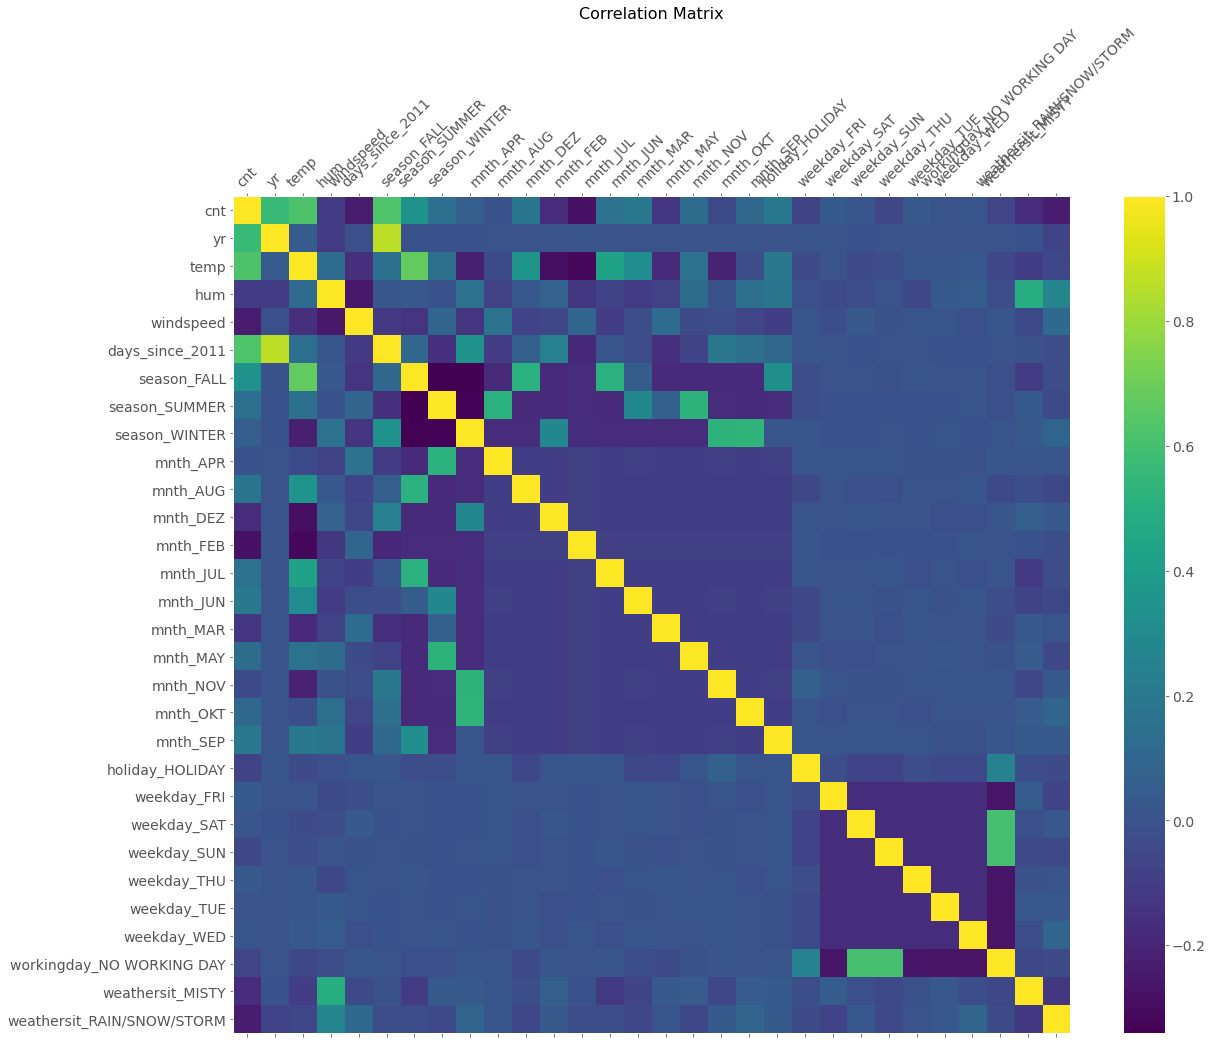

In [8]:
df = bike_rental_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

We will introduce two ways to deal with multicolinearity in linear regression: 
* **VIF**
* **Lasso**

#### VIF

The `Variance Inflation Factor` (VIF) is a measure of multicolinearity among predictors within a multiple regression task. It is the quotient of the variance in a model with multiple predictors by the variance of a model with a single predictor. More explanation of the theory can be found [here](https://en.wikipedia.org/wiki/Variance_inflation_factor). 

Steps for using VIF to deal with multicolineartiy are:

1. Initialise ```L``` as the list of independent variables. (*HINT*: the response variable is not needed here)
2. Calculate the VIF for each variable in ```L```. (*HINT*: the order of computing VIF is irrelevant).
3. If the highest VIF is larger than the threshold, remove the variable from the list ```L```.
4. Repeat Step 2-3, until no VIF is larger than the threshold.
5. Return ```L```.

It is worth noting that there are some situations (at least three) in which a high VIF is not a problem and can be safely ignored. One such situation is when *The variables with high VIFs are indicator (dummy) variables that represent a categorical variable with three or more categories*. This because these dummy variables are likely to be correlated if the proportion of cases in the reference cateogry is small. 

If you want to know more about this topic, you can read [this blog](https://statisticalhorizons.com/multicollinearity).

Below is an example of using VIF on the `bike_rental` dataset. Note that the `statsmodels` package is used.

In [9]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const').drop(list_var_not_to_remove)
        
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [10]:
# using VIF on the bike_rental dataset
predictors_bike_rental = bike_rental_final.drop('cnt', axis=1)
response_bike_rental = bike_rental_final['cnt']

# this is a list of dummy variables that represent a categorical variable with three or more categories. They should not be removed even if it has a high VIF. 
list_var_not_to_remove = ['season_SUMMER', 'season_FALL', 'season_WINTER', 'mnth_APR', 'mnth_AUG', 'mnth_DEZ',
       'mnth_FEB', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV',
       'mnth_OKT', 'mnth_SEP', 'weekday_FRI', 'weekday_SAT', 'weekday_SUN',
       'weekday_THU', 'weekday_TUE', 'weekday_WED', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM']
df_predictors_select_VIF = drop_column_using_vif_(predictors_bike_rental, list_var_not_to_remove, thresh=2.5)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

C:\Users\HuanfaChen\Anaconda3\envs\sds2020\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Max VIF: inf
Dropping: holiday_HOLIDAY
Max VIF: 581.9430735101928
Dropping: days_since_2011
Max VIF: 8.651490561143063
Dropping: workingday_NO WORKING DAY
Max VIF: 6.982402679702805
Dropping: temp
Max VIF: 1.9872613777421493
The columns remaining after VIF selection are:
Index(['yr', 'hum', 'windspeed', 'season_FALL', 'season_SUMMER',
       'season_WINTER', 'mnth_APR', 'mnth_AUG', 'mnth_DEZ', 'mnth_FEB',
       'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV', 'mnth_OKT',
       'mnth_SEP', 'weekday_FRI', 'weekday_SAT', 'weekday_SUN', 'weekday_THU',
       'weekday_TUE', 'weekday_WED', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')


## Linear regression

Now we can fit a linear regression model after dealing with the multicolinearity, and we will do it using the sklearn package. 

Just like clustering analysis in `sklearn`, we will run the regression model using the `.fit()` function. Make sure you get the variables the right way around.

In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X=df_predictors_select_VIF, y=response_bike_rental)

LinearRegression()

Now that we've created our fit, it's time to look at the structure of the model and how well it fits the data.

There are a number of ways to do this. In the first instance, as with any linear regression model, we want to get a grip on the coefficients and intercept of the model. Helpfully, these two functions are built into the LinearRegression object. **Consult the documentation and see if you can find out how to extract these.**

In [12]:
print('Constant term: ', lr.intercept_)
df_coef_lr_VIF = pd.DataFrame({"var": df_predictors_select_VIF.columns.values, "coef":lr.coef_})
print(df_coef_lr_VIF)

Constant term:  -4254055.766951831
                           var                                     coef
0                           yr                               2,116.4839
1                          hum                                  -6.7672
2                    windspeed                                 -40.1674
3                  season_FALL                               1,120.6563
4                season_SUMMER                                 877.6332
5                season_WINTER                               1,785.3621
6                     mnth_APR                               1,514.6099
7                     mnth_AUG                               2,206.0450
8                     mnth_DEZ                                 139.5015
9                     mnth_FEB                                 426.8130
10                    mnth_JUL                               2,021.6108
11                    mnth_JUN                               2,420.1333
12                    mnth_MA

The code below will generate the R2 score for us. Run the code and see how well the model performed.

In [13]:
print('R2:')
lr.score(X=df_predictors_select_VIF, y=response_bike_rental)

R2:


0.8207833700022252

It is not easy to get a comprehensive summary of the regression model using `sklearn` package. We recommend using the `statsmodel` package, which has a nice **summary()** function.

In [14]:
# fit a lineare regression model using statsmodel
regressor_OLS = sm.OLS(endog=response_bike_rental, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     129.2
Date:                Mon, 22 Feb 2021   Prob (F-statistic):          1.19e-243
Time:                        16:58:16   Log-Likelihood:                -5941.3
No. Observations:                 731   AIC:                         1.193e+04
Df Residuals:                     705   BIC:                         1.205e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.254e+06   1.25e+05    -33.903      0.000    -4.5e+06   -4.01e+06
yr                          2116.4839     62.368     33.935      0.000    1994.035    2238.933
hum                           -6.7672      3.057     -2.214      0.027     -12.769      -0.765
windspeed                    -40.1674      6.565     -6.118      0.000     -53.057     -27.278
season_FALL                 1120.6563    229.512      4.883      0.000     670.048    1571.264
season_SUMMER                877.6332    194.657      4.509      0.000     495.456    1259.810
season_WINTER               1785.3621    195.000      9.156      0.000    1402.512    2168.212
mnth_APR                    1514.6099    247.055      6.131      0.000    1029.559    1999.661
mnth_AUG                    2206.0450    274.244      8.044      0.000    1667.613    2744.477
mnth_DEZ                     139.5015    195.979      0.712      0.477    -245.272     524.275
mnth_FEB                     426.8130    153.283      2.784      0.006     125.867     727.759
mnth_JUL                    2021.6108    274.341      7.369      0.000    1482.987    2560.234
mnth_JUN                    2420.1333    238.866     10.132      0.000    1951.160    2889.107
mnth_MAR                    1262.1342    165.307      7.635      0.000     937.581    1586.688
mnth_MAY                    2265.0846    246.320      9.196      0.000    1781.476    2748.693
mnth_NOV                     221.8367    246.601      0.900      0.369    -262.323     705.997
mnth_OKT                    1375.7295    246.360      5.584      0.000     892.042    1859.417
mnth_SEP                    2341.0241    252.529      9.270      0.000    1845.225    2836.823
weekday_FRI                  298.3976    115.894      2.575      0.010      70.859     525.937
weekday_SAT                  273.3865    115.409      2.369      0.018      46.799     499.974
weekday_SUN                 -183.8554    115.331     -1.594      0.111    -410.289      42.578
weekday_THU                  299.4629    115.885      2.584      0.010      71.942     526.983
weekday_TUE                  209.4256    115.591      1.812      0.070     -17.519     436.370
weekday_WED                  275.6144    115.913      2.378      0.018      48.038     503.191
weathersit_MISTY            -620.4733     82.047     -7.562      0.000    -781.560    -459.387
weathersit_RAIN/SNOW/STORM -2266.9761    211.046    -10.742      0.000   -2681.330   -1852.622
==============================================================================
Omnibus:                      123.461   Durbin-Watson:                   1.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              423.049
Skew:                          -0.779   Prob(JB):                     1.37e-92
Kurtosis:   

We can see that the R2 value of 0.82 is quite high, which means that 82% of the variance in the daily bike rental can be explained by the predictors used.

The next step is interpreting this model. Regarding the humnidity, an increase of the humidity by 1% decreases the predicted bike rental count by 6.7672, when all other variables remain fixed. In terms of seasons, when it is fall, the predicted number of bike rental is 1120.6 higher compared to the spring season, when all other variables remain fixed. (So people like travelling by bicycle in fall more than in spring?)

As a practice, can you interpret the other variables in this model?

## Lasso

The full name of Lasso is **least absolute shrinkage and selection operator**. It is a regression method that performs both variable selection and regularisation (or penalty) in order to increase the prediction accuracy and interpretability of the regression model.

In Lasso, the lambda (or alpha) parameter controls the strength of regularisation. If alpha=0, it is equivalent to an ordinary least square. In the Lasso function provided by `sklearn`, the alpha value defaults to 1.0.

Please note that Lasso requires predictors to be normalised. This can be done using this function by setting `normalize=True`. Here, normalisation means subtracting the mean and dividing by the standard deviation.

In [15]:
from sklearn import linear_model
# increase the max_iter to guarantee convergence
lasso_model = linear_model.Lasso(max_iter=10e7, normalize=True)
lasso_model.fit(X=predictors_bike_rental, y=response_bike_rental)

Lasso(max_iter=100000000.0, normalize=True)

In [16]:
lasso_model.score(X=predictors_bike_rental, y=response_bike_rental)

0.8390091540236089

It looks like the Lasso model has done a great job in fitting the relationship between the response and predictors.

We can check out the coefficients using the following code.

In [17]:
# print(lasso_model.coef_)
df_coef_lasso = pd.DataFrame({"var": predictors_bike_rental.columns.values, "coef":lasso_model.coef_})
print(df_coef_lasso)

                           var                                     coef
0                           yr                               1,550.8523
1                         temp                                 114.9116
2                          hum                                 -14.7020
3                    windspeed                                 -39.9598
4              days_since_2011                                   1.1011
5                  season_FALL                                 263.0961
6                season_SUMMER                                 772.3289
7                season_WINTER                                 924.7247
8                     mnth_APR                                   0.0000
9                     mnth_AUG                                  53.3674
10                    mnth_DEZ                                -210.0024
11                    mnth_FEB                                 -39.0702
12                    mnth_JUL                                -1

We can apply the Lasso regression with a range of lambda parameters, and see how the coefficients change with the lambda value. The plot is called `LASSO Path`.

(-1.25, 4.25, -617.3125241650608, 1241.775682199666)

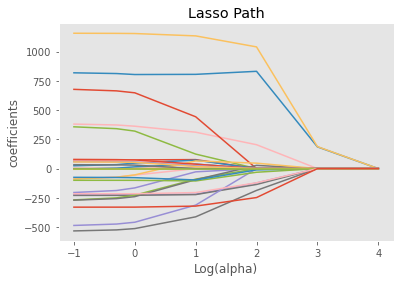

In [18]:
from itertools import cycle
from sklearn.linear_model import lasso_path

predictors_bike_rental_standardised = predictors_bike_rental/predictors_bike_rental.std(axis=0)

# alphas_lasso, coefs_lasso, _ = lasso_path(predictors_bike_rental, response_bike_rental, alphas = [.1, .5, 1, 10, 100], fit_intercept=False)
alphas_lasso, coefs_lasso, _ = lasso_path(predictors_bike_rental_standardised, response_bike_rental.values.reshape(-1),alphas = [.1, .5, 1, 10, 100, 1000, 10000], fit_intercept=False)
# print(alphas_lasso.shape)
# print(coefs_lasso.shape)

log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')

If you are interested in how to select the optimal lambda value, [this link](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py) would be very useful.

## Regression Tree

In this section, we will use a regression tree for this dataset. Although there are several parameters in this model such as **max_depth** (corresponding to the height of a tree), but in a first attempt we just use the default values.

In [19]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=0)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(predictors_bike_rental, response_bike_rental)

DecisionTreeRegressor(random_state=0)

Just like the previous regressors, you can check the R2 score using the `score()` function.

In [20]:
reg_tree.score(X=predictors_bike_rental, y=response_bike_rental)

1.0

It looks like the fitting is perfect with a R2 score of 1. But don't get carried away. Probably the model has **overfitted**. This means that the model fits perfectly on the **given** dataset at the cost of doing badly on the **unseen** dataset. We will talk about this issue in later lectures and workshops.

## Random Forest

In this section, we will use the random forest method for this dataset.

In [21]:
from sklearn.ensemble import RandomForestRegressor
reg_random_forest = RandomForestRegressor(random_state=0)
reg_random_forest.fit(predictors_bike_rental, response_bike_rental.values.reshape(-1))

RandomForestRegressor(random_state=0)

We can check the R2 score of this model.

In [22]:
reg_random_forest.score(X=predictors_bike_rental, y=response_bike_rental)

0.9834835122944702

Again, we have got a very good R2 score. We need to look into the overfitting issue, but this is not the topic in this workshop.

## To be continued

Well done for completing this workshop on regression. You will now have a stronger understanding of how to use a range of regression methods to gain insights into your datasets.

If you have time and/or interest in exploring these methods further, then you might wan to try one or more of these activities:

0. We have not done a lot to interpret the models. If you have time and energy, here is a handy book on interpretation of statistics and machine learning models. For linear regression, please read this [this chapter](https://christophm.github.io/interpretable-ml-book/limo.html). For decision trees, have a look at [this chapter](https://christophm.github.io/interpretable-ml-book/tree.html). If you want to interpret a random forest, you can try the **permutation feature importance** method, which is introduced in [this chapter](https://christophm.github.io/interpretable-ml-book/feature-importance.html).
1. We committed a methodological sin in reusing the same dataset for model fitting and validation (calculting the goodness-of-fit). There are ways around this problem, either by using another dataset, or by splitting the dataset into parts for *cross-validation*. Look at the documentation on cross-validation [here](ttp://scikit-learn.org/stable/modules/cross_validation.html)and then implement a simple technique to avoid this problem.
2. There are lots of nice datasets for analysis on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html) and [Kaggle](https://www.kaggle.com/datasets). Take a look, and if any of them take your fancy try create a regression model. Which data features are important? Which are not? 

## Credits!

### Acknowledgements

This workshop is partially based on a [chapter](https://christophm.github.io/interpretable-ml-book/limo.html) of the [book](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar. 